[Table of Contents](http://nbviewer.ipython.org/github/rlabbe/Kalman-and-Bayesian-Filters-in-Python/blob/master/table_of_contents.ipynb)

# Multivariate Gaussians

In [2]:
#format the book
%matplotlib inline
from __future__ import division, print_function
from book_format import load_style, set_figsize, figsize
load_style()

## Introduction

Let's review where we have been and where we are going. We developed a discrete Bayes filter that was able to track a moving object. It did that by assigning ad hoc probabilities to our belief in motions, movement, and measurements, and then computed the probability of an object being in every part of the (bounded) world. This is computationally expensive, but it did work. Next we introduced modelling probability distributions as Gaussians, and introduced the Bayesian notion that these distributions are *beliefs*. If I say a robot is at $x=\mathcal{N}(22,4)$ than I believe  the robot is in the vicinity of $x=22$, and that I think there is a 68% chance that the robot is within $\pm\sigma=\sqrt{4}=2$ of 22. I.e., the robot has a 68% chance of being somewhere between 20 and 24. We then used that math with the discrete Bayes algorithm to create a very powerful one dimensional Kalman filter.

But the world is not one dimensional, and I don't just mean in space. If a robot moves, it also has velocity and acceleration, and from the point of view of the mathematics we are doing we treat those as dimensions as well. So if we want to track an airplane in 3D space we might need estimates for 9 parameters, or 12 if we include attitude (pitch, roll, yaw). The math and algorithms that we have learned so far do not give us a way to do that.

So in this chapter I will teach you how to extend Gaussians in multiple dimensions. Once you understand this you will be ready to understand the next chapter, where we extend the Kalman filter to work in multiple dimensions. When I put it like that it sounds a bit pedestrian, but some amazing things are going to come from this math - we will be able to track with far greater accuracy than we have so far. The secret to that comes in the next chapter. 

I took the time to write that because I want you to understand how important the math in this chapter is. There will not be a lot of physical examples like in the rest of the book to ground what you are learning, but please persevere; understanding the material in this chapter is not very hard, and once you do it will make the Kalman filter very accessible. It is also the math behind machine learning, control theory, much of computer vision - just about any system with a lot of data and uncertainty. 

## Multivariate Normal Distributions

What might a *multivariate normal distribution* look like? In this context, multivariate just means multiple variables. Our goal is to be able to represent a normal distribution across multiple dimensions. Consider the 2 dimensional case. Let's say we believe that $x = 2$ and $y = 17$. This might be the *x* and *y* coordinates for the position of our dog, it might be the  position and velocity of our dog on the x-axis, or the temperature and wind speed at our weather station, it doesn't really matter. We can see that for $N$ dimensions, we need $N$ means, which we will arrange in a vector like so:

$$
\mu = \begin{bmatrix}{\mu}_1\\{\mu}_2\\ \vdots \\{\mu}_n\end{bmatrix}
$$

Therefore for this example we would have

$$
\mu = \begin{bmatrix}2\\17\end{bmatrix} 
$$

The next step is representing our variances. At first blush we might think we would also need N variances for N dimensions. We might want to say the variance for x is 10 and the variance for y is 4, like so. 

$$\sigma^2 = \begin{bmatrix}10\\4\end{bmatrix}$$ 

This is incorrect because it does not consider the more general case. For example, suppose we were tracking house prices vs total $m^2$ of the floor plan. These numbers are *correlated*. It is not an exact correlation, but in general houses in the same neighborhood are more expensive if they have a larger floor plan. We want a way to express not only what we think the variance is in the price and the $m^2$, but also the degree to which they are correlated. It turns out that we use the following matrix to denote *covariances* with multivariate normal distributions. You might guess, correctly, that *covariance* is short for *correlated variances*.

$$
\Sigma = \begin{bmatrix}
  \sigma_1^2 & \sigma_{12} & \cdots & \sigma_{1n} \\
  \sigma_{21} &\sigma_2^2 & \cdots & \sigma_{2n} \\
  \vdots  & \vdots  & \ddots & \vdots  \\
  \sigma_{n1} & \sigma_{n2} & \cdots & \sigma_n^2
 \end{bmatrix}
$$

If you haven't seen this before it is probably a bit confusing at the moment. Rather than explain the math right now, we will take our usual tactic of building our intuition first with various physical models. At this point, note that the diagonal contains the variance for each state variable, and that all off-diagonal elements (covariances) are represent how much the $i$th (row) and $j$th (column) state variable are linearly correlated to each other. In other words, the covariance is a measure for how much they change together. A covariance of 0 indicates no correlation. So, for example, if the variance for x is 10, the variance for y is 4, and there is no linear correlation between x and y, then we would say

$$\Sigma = \begin{bmatrix}10&0\\0&4\end{bmatrix}$$

If there was a small amount of correlation between x and y we might have

$$\Sigma = \begin{bmatrix}10&1.2\\1.2&4\end{bmatrix}$$

where 1.2 is the covariance between x and y. Note that this is always symmetric - the covariance between x and y is always equal to the covariance between y and x. That is, $\sigma_{xy}=\sigma_{yx}$ for any x and y. This makes sense - if the price of the house is correlated with the size of the floor plan, the size of the floor plan is correlated with the price of a house by the same amount. It is two different ways of expressing the same relation.

Now, without explanation, here is the full equation for the multivariate normal distribution in $n$ dimensions.

$$\mathcal{N}(\mu,\,\Sigma) = (2\pi)^{-\frac{n}{2}}|\Sigma|^{-\frac{1}{2}}\, e^{ -\frac{1}{2}(\mathbf{x}-\mu)^\mathsf{T}\Sigma^{-1}(\mathbf{x}-\mu) }$$

I urge you to not try to remember this equation. We will program it in a Python function and then call it when we need to compute a specific value. However, if you look at it briefly you will note that it looks quite similar to the *univariate normal distribution*  except it uses matrices instead of scalar values, and the root of $\pi$ is scaled by $n$. Here is the *univariate* equation for reference:

$$ 
f(x, \mu, \sigma) = \frac{1}{\sigma\sqrt{2\pi}} e^{{-\frac{1}{2}}{(x-\mu)^2}/\sigma^2 }
$$

The multivariate version merely replaces the scalars of the univariate equations with matrices. If you are reasonably well-versed in linear algebra this equation should look quite manageable; if not, don't worry! Let's just plot it and see what it looks like.

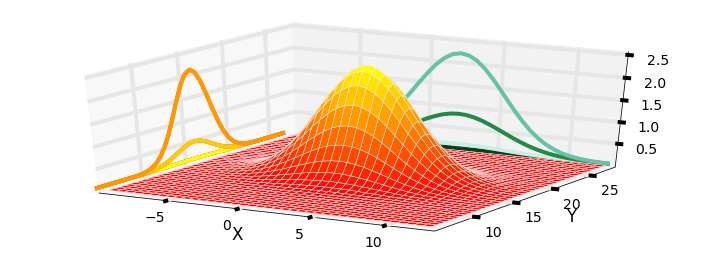

In [3]:
import mkf_internal
import numpy as np
mkf_internal.plot_3d_covariance((2, 17), np.array([[10., 0], [0, 4.]]))

Here we have plotted a two dimensional multivariate Gaussian with a mean of $\mu=[\begin{smallmatrix}2\\17\end{smallmatrix}]$ and a covariance of $\Sigma=[\begin{smallmatrix}10&0\\0&4\end{smallmatrix}]$. The three dimensional shape shows the probability of for any value of (x,y) in the z-axis. I have projected just the variance for x and y onto the walls of the chart - you can see that they take on the normal Gaussian bell curve shape. You can also see that, as we might hope, that the curve for x is wider than the curve for y, which is explained by $\sigma_x^2=10$ and $\sigma_y^2=4$. Also, the highest point of the curve is centered over (2,17), the means for x and y. I hope this demystifies the equation for you. Any multivariate Gaussian will create this sort of shape. If we think of this as a the Gaussian for our dog's position in a two dimensional field, the z-value at each point of (x,y) is the probability density for the dog being at that position. So, he has the highest probability of being near (2,17), a modest probability of being near (5,14), and a very low probability of being near (10,10).

We will discuss the mathematical description of covariances in the Kalman Filter math chapter. For this chapter we just need to understand the following.

1. The diagonal of the matrix contains the variance for each variable. 

2. Each off-diagonal element contains $\sigma_{ij}$ - the covariance between *i* and *j*. This tells us how much linear correlation there is between the two variables. 0 means no correlation, and as the number gets higher the correlation gets greater.

3. $\sigma_{ij} = \sigma_{ji}$

4. The covariance between x and itself is just the variance of x: $\sigma_{xx} = \sigma_x^2$.

5. This chart only shows a 2 dimensional Gaussian, but the equation works for any number of dimensions >= 1. It's kind of hard to show a chart for the higher dimensions.

I have programmed the multivariate Gaussian equation and saved it in the file `stats.py` with the function name `multivariate_gaussian`. I am not showing the code here because I have taken advantage of the linear algebra solving apparatus of NumPy to efficiently compute a solution - the code does not correspond to the equation in a one to one manner. If you wish to view the code, I urge you to either load it in an editor, or load it into this worksheet by putting `%load -s multivariate_gaussian stats.py` in the next cell and executing it with CTRL-enter. 

However, please note that the Kalman filter equations incorporate this computation automatically; you will not be using this function very often in this book, so I would not spend a lot of time mastering this function unless it interests you.

>As of version 0.14 scipy.stats has implemented the multivariate normal equation with the function `multivariate_normal()`. It implements a 'frozen' form where you set the mean and covariance once, and then calculate the probability for any number of values for x over any arbitrary number of calls. This is much more efficient then recomputing everything in each call. So, if you have version 0.14 or later you may want to substitute my function for the built in version. Use `scipy.version.version` to get the version number. I deliberately named my function `multivariate_gaussian()` to ensure it is never confused with the built in version. I will say that for a single call, where the frozen variables do not matter, mine consistently runs faster as measured by the `timeit` function.

> The <a href="http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html">tutorial</a>[1] for the `scipy.stats` module explains 'freezing' distributions and other very useful features. As of this date, it includes an example of using the multivariate_normal function, which does work a bit differently from my function.

In [4]:
from stats import gaussian, multivariate_gaussian

Let's use it to compute a few values just to make sure we know how to call and use the function, and then move on to more interesting things.

First, let's find the probability density for our dog being at (2.5, 7.3) if we believe he is at (2, 7) with a variance of 8 for $x$ and a variance of 4 for $y$.

Start by setting $x$ to (2.5, 7.3):

In [5]:
x = [2.5, 7.3]

Next, we set the mean of our belief:

In [6]:
mu = [2.0, 7.0]

Finally, we have to define our covariance matrix. In the problem statement we did not mention any correlation between $x$ and $y$, and we will assume there is none. This makes sense; a dog can choose to independently wander in either the $x$ direction or $y$ direction without affecting the other. If there is no correlation between the values you just fill in the diagonal of the covariance matrix with the variances. I will use the seemingly arbitrary name $\textbf{P}$ for the covariance matrix. The Kalman filters use the name $\textbf{P}$ for this matrix, so I will introduce the terminology now to avoid explaining why I change the name later. 

In [7]:
P = [[8.,  0.], 
     [0., 4.]]

Now just call the function

In [8]:
print('{:.4}'.format(multivariate_gaussian(x, mu, P)))

0.02739


> Note that the function can accept lists, np.array, or np.matrix as arguments, or even scalars. Type `multivariate_gaussian?` in a cell and press CTRL-enter to get the help for this function. 

These numbers are not easy to interpret. Let's plot this in 3D, with the $z$ (up) coordinate being the probability distribution.

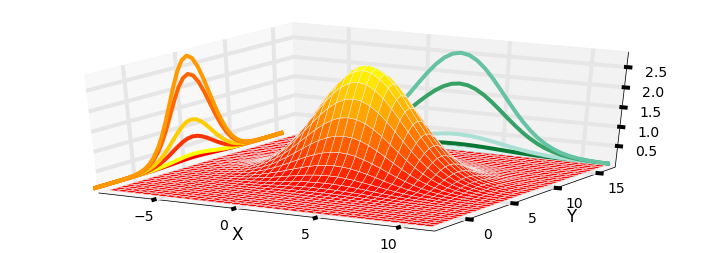

In [9]:
import mkf_internal
mkf_internal.plot_3d_covariance(mu, P)

The result is clearly a 3D bell shaped curve. We can see that the Gaussian is centered around (2,7), and that the probability density quickly drops away in all directions. On the sides of the plot I have drawn the Gaussians for $x$ in greens and for $y$ in orange.

Let's look at this in a slightly different way. Instead of plotting a surface showing the probability distribution I will just generate 1,000 points with the distribution of $[\begin{smallmatrix}8&0\\0&4\end{smallmatrix}]$.

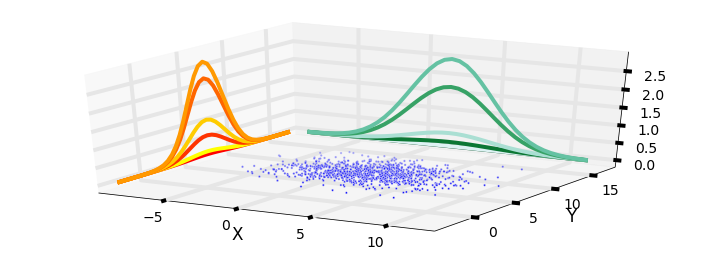

In [10]:
mkf_internal.plot_3d_sampled_covariance(mu, P)

We can think of the sampled points as being possible locations for our dog given those particular mean and covariances. The contours on the side show the variance in the points for $x$ and $y$ only.

As beautiful as this is, it is perhaps a bit hard to get useful information. For example, it is not easy to tell if $x$ and $y$ both have the same variance or not. So for most of the rest of this book we will display multidimensional Gaussian using contour plots. I will use some helper functions in `stats.py` to plot them. If you are interested in linear algebra go ahead and look at the code used to produce these contours, otherwise feel free to ignore it. 

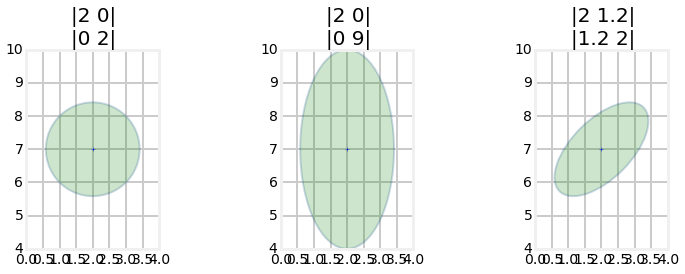

In [11]:
import matplotlib.pyplot as plt
import stats

set_figsize(y=4)

P = np.array([[2, 0], [0, 2]])
plt.subplot(131)
stats.plot_covariance_ellipse((2, 7), cov=P, facecolor='g', alpha=0.2, 
                              title='|2 0|\n|0 2|', axis_equal=False)
plt.ylim((4, 10))
plt.gca().set_aspect('equal', adjustable='box')

plt.subplot(132)
P = np.array([[2, 0], [0, 9]])
plt.ylim((4, 10))
plt.gca().set_aspect('equal', adjustable='box')
stats.plot_covariance_ellipse((2, 7), P, facecolor='g', alpha=0.2, 
                              axis_equal=False, title='|2 0|\n|0 9|')

plt.subplot(133)
P = np.array([[2, 1.2], [1.2, 2]])
plt.ylim((4, 10))
plt.gca().set_aspect('equal', adjustable='box')
stats.plot_covariance_ellipse((2, 7), P, facecolor='g', alpha=0.2, 
                              axis_equal=False, 
                              title='|2 1.2|\n|1.2 2|')

plt.tight_layout()
plt.show()

And for those of you viewing this online or in IPython Notebook on your computer, here is an animation.
<img src='animations/multivariate_ellipse.gif'>

From a mathematical perspective these display the values that the multivariate Gaussian takes for a specific standard deviation. This is like taking a horizontal slice out of the 3D plot. By default it displays one standard deviation, but you can use the `variance` parameter to control what is displayed. For example, `variance=3**2` would display the 3rd standard deviation, and `variance=[1,4,9]` would display the 1st, 2nd, and 3rd standard deviations as in the chart below. This takes 3 different horizontal slices of the multivariate Gaussian chart and displays them in 2D.

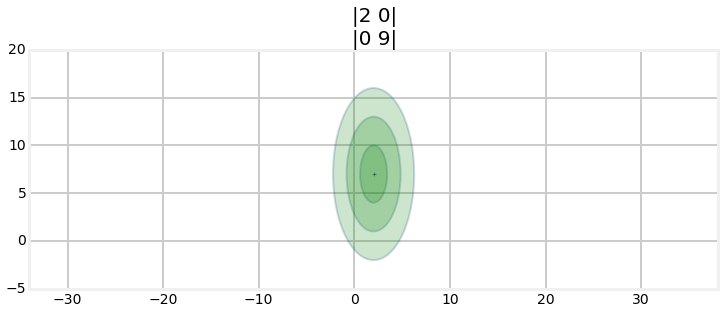

In [12]:
P = np.array([[2, 0], [0, 9]])

stats.plot_covariance_ellipse((2, 7), P, facecolor='g', alpha=0.2, 
                              variance=[1, 2**2, 3**2],
                              axis_equal=True, title='|2 0|\n|0 9|')

Thinking about the physical interpretation of these plots clarifies their meaning. The first plot uses the mean and covariance matrices of

$$
\begin{aligned}
\mathbf{\mu} &=\begin{bmatrix}2\\7\end{bmatrix} \\
\Sigma &= \begin{bmatrix}2&0\\0&2\end{bmatrix}
\end{aligned}
$$ 

Let this be our current belief about the position of our dog in a field. In other words, we believe that he is positioned at (2,7) with a variance of $\sigma^2=2$ for both x and y. The contour plot shows where we believe the dog is located with the '+' in the center of the ellipse. The ellipse shows the boundary for the $1\sigma$ probability, where $1\sigma$ is one *standard deviation*. In other words, for this Gaussian 68% of the data will fall within this ellipse. Recall from the Gaussians chapter the the 68-95-99.7 rule - 68% of all values will fall within 1 standard deviation ($1\sigma$), 95% within $2\sigma$, and 99.7% within $3\sigma$. The dog could be at (356443,58483), but the chances for values that far away from the mean are infinitesimally small.

An equivalent way of thinking about this is the circle/ellipse shows us the amount of error in our belief. A tiny circle would indicate that we have a very small error, and a very large circle indicates a lot of error in our belief. We will use this throughout the rest of the book to display and evaluate the accuracy of our filters at any point in time. 

The second plot uses the mean and covariance matrices of

$$
\begin{aligned}
\mu &=\begin{bmatrix}2\\7\end{bmatrix} \\
\Sigma &= \begin{bmatrix}2&0\\0&9\end{bmatrix}
\end{aligned}
$$

This time we use a different variance for $x$ (2) vs $y$ (9). The result is an ellipse. When we look at it we can immediately tell that we have a lot more uncertainty in the $y$ value vs the $x$ value. Our belief that the value is (2,7) is the same in both cases, but errors are different. In this case the standard deviation in $x$ is $\sigma_x = \sqrt{2}=1.414$ and the standard deviation for $y$ is $\sigma_y = \sqrt{9}=3$. This sort of thing happens naturally as we track objects in the world - one sensor has a better view of the object, or is closer, than another sensor, and so we end up with different error rates in the different axis.

The third plot uses the mean and covariance matrices of:

$$
\begin{aligned}
\mu &=\begin{bmatrix}2\\7\end{bmatrix} \\
\Sigma &= \begin{bmatrix}2&1.2\\1.2&2\end{bmatrix}
\end{aligned}
$$

This is the first contour that has values in the off-diagonal elements of $cov$, and this is the first contour plot with a slanted ellipse. This is not a coincidence. The two facts are telling use the same thing. A slanted ellipse tells us that the $x$ and $y$ values are somehow **correlated**. We denote that in the covariance matrix with values off the diagonal. What does this mean in physical terms? Think of trying to park your car in a parking spot. You can not pull up beside the spot and then move sideways into the space because most cars cannot go purely sideways. $x$ and $y$ are not independent. This is a consequence of the steering system in a car. When your tires are turned the car rotates around its rear axle while moving forward. Or think of a horse attached to a pivoting exercise bar in a corral. The horse can only walk in circles, he cannot vary $x$ and $y$ independently, which means he cannot walk straight forward to to the side. If $x$ changes, $y$ must also change in a defined way. 

So when we see this ellipse we know that $x$ and $y$ are correlated, and that the correlation is "strong". The size of the ellipse shows how much error we have in each axis, and the slant shows how strongly correlated the values are.

Let's look at this in a graph and then reason about it. Let's assume that we have a covariance for the position of our dog, which we believe is at coordinate (5, 10) meters. If the standard deviation in x and y is each 2 meters, but they are strongly correlated, our covariance contour would look like this.

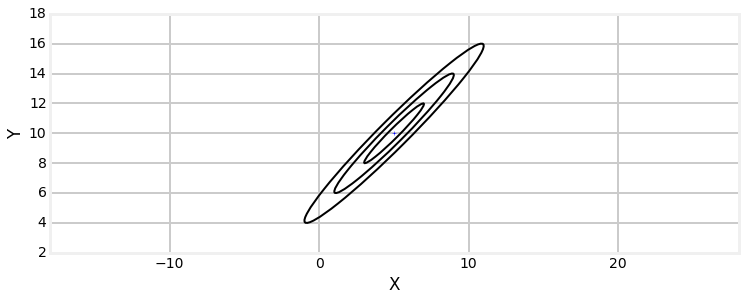

In [13]:
P = np.array([[4, 3.9], [3.9, 4]])
stats.plot_covariance_ellipse((5, 10), P, edgecolor='k', 
                              variance=[1, 2**2, 3**2])
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

Now suppose I were to tell you that the actual position of the dog in the *x* dimension is 7.5, what can we infer about his position in *y*? The position is extremely likely to lie within the 3$\sigma$ covariance, as in the chart below. We can *infer* the like position in *y* based on the covariance matrix because there is a correlation between *x* and *y*.

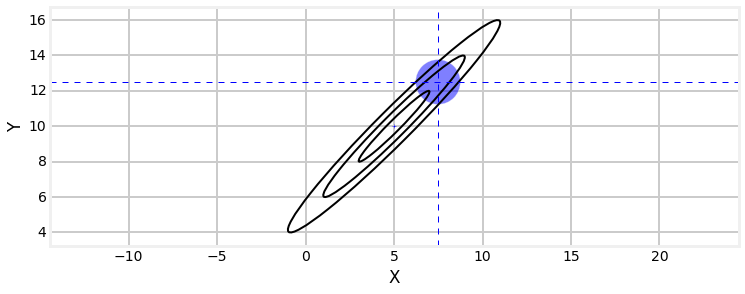

In [14]:
P = np.array([[4, 3.9], [3.9, 4]])
stats.plot_covariance_ellipse((5, 10), P, edgecolor='k', 
                              variance=[1, 2**2, 3**2])
plt.xlabel('X')
plt.ylabel('Y')
plt.gca().autoscale(tight=True)
plt.axvline(7.5, ls='--', lw=1)
plt.axhline(12.5, ls='--', lw=1)
plt.scatter(7.5, 12.5, s=2000, alpha=0.5)
plt.plot()
plt.show()

A word about **correlation** and **independence**. If variables are **independent** they can vary separately. If you walk in an open field, you can move in the $x$ direction (east-west), the $y$ direction(north-south), or any combination thereof. Independent variables are always also **uncorrelated**. Except in special cases, the reverse does not hold true. Variables can be uncorrelated, but dependent. For example, consider the pair$(x,y)$ where $y=x^2$. Correlation is a linear measurement, so $x$ and $y$ are uncorrelated. However, they are obviously dependent on each other. 

## Computing Means and Covariances

You will not need to do this by hand for the rest of the book, but it is important to understand the computations behind these values. It only takes a few minutes to learn.

### Computing the Mean

So let's start with 3 variables: $a, b, c$. Let's say we have two values for each: $a = [1, 3]$, $b = [8, 7]$, and $c = [3,7]$. Another, equivalent way of writing this is that you will sometimes see is

$$\mathbf{x} = \begin{bmatrix}a\\b\\c\end{bmatrix} = \begin{bmatrix}1 & 3\\8&7\\3&7\end{bmatrix}$$

You will not see that often in the Kalman filter literature, so I will adopt the alternative notation of using a subscript to indicate the $i^{th}$ value for $\mathbf{x}$

$$\mathbf{x}_0 = \begin{bmatrix}1 \\8\\3\end{bmatrix},\ \  \mathbf{x}_1 = \begin{bmatrix}3\\7\\7\end{bmatrix}$$

We compute the mean just as for the univariate case, which we presented in the *Gaussians* chapter. Sum the values and divide by the number of values. Formally

$$ \mu_x = \frac{1}{n}\sum^n_{i=1} x_i$$

Therefore we can write:

$$\begin{aligned}
\mu_a &= \frac{1+3}{2} = 2 \\
\mu_b &= \frac{8+7}{2} = 7.5 \\
\mu_c &= \frac{3+7}{2} = 5 
\end{aligned}$$

Which I can express in our shorthand matrix notation as

$$\mu_x = \begin{bmatrix}2\\7.5\\5\end{bmatrix}$$

### Expected Value

I could just give you the formula for the covariance but it will make more sense if you see how it is derived. To do that we first need to talk about *expected value* of a random variable. The expected value is just the value we expect, on average, for the variable. 

The *expected value* of a random variable is just the average value it would have if we took an infinite number of samples of it and then averaged those samples together. Let's say we have $x=[1,3,5]$ and each value is equally probable. What would we *expect* $x$ to have, on average?

It would just be the average of 1, 3, and 5, of course, which is 3. That should make sense; we would expect equal numbers of 1, 3, and 5 to occur, so $(1+3+5)/3=3$ is clearly the average of that infinite series of samples.

Now suppose that each value has a different probability of happening. Say 1 has an 80% chance of occurring, 3 has an 15% chance, and 5 has only a 5% chance. In this case we compute the expected value by multiplying each value of $x$ by the percent chance of it occurring, and summing the result. So for this case we could compute

$$E[x] = (1)(0.8) + (3)(0.15) + (5)(0.05) = 1.5$$

Here I have introduced the standard notation $E[x]$ for the expected value of $x$.

We can formalize this by letting $x_i$ be the $i^{th}$ value of $x$, and $p_i$ be the probability of its occurrence. This gives us

$$E[X] = \sum_{i=1}^n p_ix_i$$

The value 1.5 for $x$ makes intuitive sense because x is far more like to be 1 than 3 or 5, and 3 is more likely than 5 as well.

It is probably worth me pointing out now that if $x$ is continuous we substitute the sum for an integral, like so

$$E[X] = \int_{-\infty}^\infty xf(x)$$

where $f(x)$ is the probability distribution function of $x$. We won't be using this equation yet, but we will be using it in the next chapter.

### Computing the Covariance


Now we are prepared to compute the covariance matrix. The *covariance* measures how much two random variables move in the same direction, and is defined as

$$ COV(x,y) = \frac{1}{N}\sum_{i=1}^N (x_i - \mu_x)(y_i - \mu_y)$$

If we compare this to the formula for the variance of a single variable we can see where this definition came from.

$$\sigma^2 = \frac{1}{N}\sum_{i=1}^N(x_i - \mu)^2$$

And indeed, the covariance of a variable with itself is just the variance of the variable, which we can trivially prove with

$$\begin{aligned}
COV(x,x) &= \frac{1}{N}\sum_{i=1}^N (x_i - \mu_x)(x_i - \mu_x) \\
&= \frac{1}{N}\sum_{i=1}^N (x_i - \mu_x)^2 \\
&= VAR(x)
\end{aligned}$$


Let's build some familiarity with this by calculating the covariance for the $\mathbf{x}$ from the beginning of this section.

$$\mathbf{x}_0 = \begin{bmatrix}1 \\8\\3\end{bmatrix},\ \  \mathbf{x}_1 = \begin{bmatrix}3\\7\\7\end{bmatrix}$$

We already know the mean is

$$\mu_x = \begin{bmatrix}2\\7.5\\5\end{bmatrix}$$

Recall that we named the three variables as $a, b, c$. Let's start by computing the variance of $a$.

$$
\begin{aligned}
VAR(a) &= \frac{1}{2}[(1-2)^2 + (3-2)^2] \\
&= \frac{1}{2}[1+1] \\
&= 1\end{aligned}$$


Using similar math we can compute that $VAR(a) = 0.25$ and $VAR(c)=4$. This allows us to fill in the covariance matrix with

$$\Sigma = \begin{bmatrix}1 & & \\ & 0.25 & \\ &&4\end{bmatrix}$$

Now we can compute the covariance of a and b.

$$
\begin{aligned}
COV(a,b) &= \frac{1}{2}[(1-2)(8-7.5) + (3-2)(7-7.5)] \\
&= \frac{1}{2}[(-1)(.5)+  (1)(-.5)] \\
&= -0.5\end{aligned}$$

We can fill in the $a^{th}$ row and $b^{th}$ column  in the covariance matrix with this value:

$$\Sigma = \begin{bmatrix}1 & & \\ -0.5 & 0.25 & \\ &&4\end{bmatrix}$$

We already talked about the symmetry of the covariance matrix; $\sigma_{ab}=\sigma_{ba}$. We see now why this is true from the equation for the covariance.

$$\begin{aligned} COV(x,y) &= \frac{1}{N}\sum_{i=1}^N (x_i - \mu_x)(y_i - \mu_y) \\
&= \frac{1}{N}\sum_{i=1}^N (y_i - \mu_y)(x_i - \mu_x) \\
&= COV(y,x)\end{aligned}$$

This gives the covariance matrix

$$\Sigma = \begin{bmatrix}1 &-0.5 & \\ -0.5 & 0.25 & \\ &&4\end{bmatrix}$$.

The arithmetic is a bit tedious, so let's just use NumPy's `cov()` function to compute the entire covariance matrix. To compute the covariance in accordance with the equations above you will need to set the parameter `bias=1`.  The meaning of that parameter is not important to this book. If you are interested, wikipedia has a good article on it here http://en.wikipedia.org/wiki/Bias_of_an_estimator.

In [15]:
x = np.array([[1, 3], [8, 7], [3, 7]])
print(np.cov(x, bias=1))

[[ 1.   -0.5   2.  ]
 [-0.5   0.25 -1.  ]
 [ 2.   -1.    4.  ]]


We said above that "the *covariance* measures how much two random variables move in the same direction", so let's see what that means in practice. If we start with the value $x_0 = (1, 2)$ we can create subsequent values that vary in the same direction with $x_1 = (2, 4)$, $x_2=(3,6)$, and $x_3=(4,8)$.

[[ 1.25  2.5 ]
 [ 2.5   5.  ]]


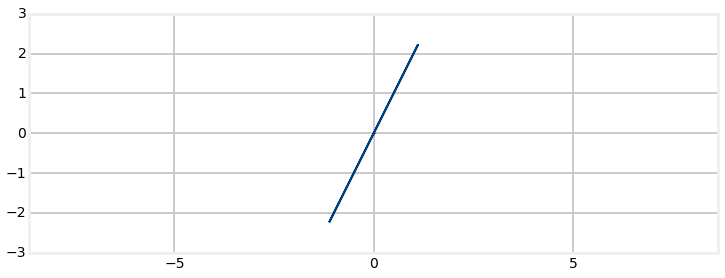

In [16]:
x = np.array([[1, 2, 3, 4], [2, 4, 6, 8]])
cov = np.cov(x, bias=1)
stats.plot_covariance_ellipse([0, 0], cov)
print(cov)

The values for $x$ are perfectly correlated, and the result is a covariance ellipse with zero width. We can see this by making the values not slightly uncorrelated.

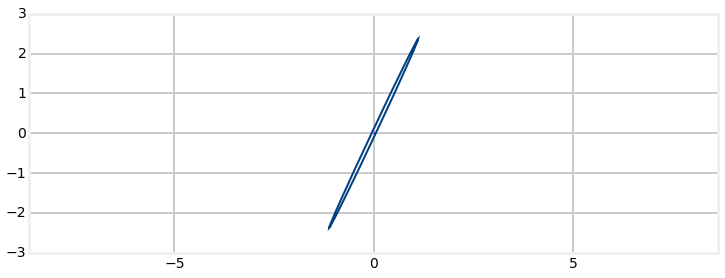

In [17]:
x = np.array([[1, 2, 3, 4], [2, 4, 6, 8.4]])
stats.plot_covariance_ellipse([0, 0], np.cov(x, bias=1))

Now lets make the second value go away from the first.

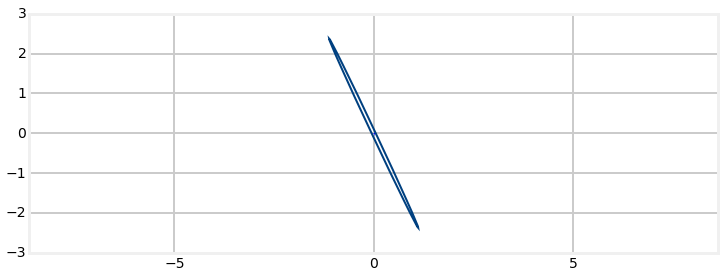

In [18]:
x = np.array([[1, 2, 3, 4], [-2, -4, -6, -8.4]])
stats.plot_covariance_ellipse([0, 0], np.cov(x, bias=1))

As we would hope, the covariance matrix is tilted in the opposite direction, indicating that the variables are inversely correlated. That is, as one gets larger, the other becomes smaller.

## Multiplying Multidimensional Gaussians

In the previous chapter we incorporated an uncertain measurement with an uncertain estimate by multiplying their Gaussians together. The result was another Gaussian with a smaller variance. If two piece of uncertain information corroborate each other we should be more certain in our conclusion. The graphs look like this:

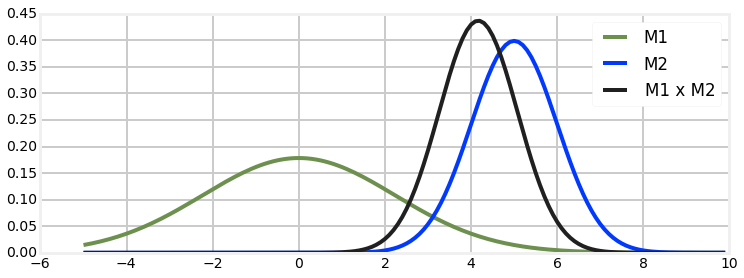

In [19]:
import stats
xs = np.arange(-5, 10, 0.1)

mean1, var1 = 0, 5
mean2, var2 = 5, 1
mean, var = stats.mul(mean1, var1, mean2, var2)

ys = [stats.gaussian(x, mean1, var1) for x in xs]
plt.plot(xs, ys, label='M1')

ys = [stats.gaussian(x, mean2, var2) for x in xs]
plt.plot(xs, ys, label='M2')

ys = [stats.gaussian(x, mean, var) for x in xs]
plt.plot(xs, ys, label='M1 x M2')
plt.legend()
plt.show()

The combination of measurement 1 and 2 yields more certainty, so the new Gaussian is taller and narrower - the variance became smaller. The same thing happens in multiple dimensions with multivariate Gaussians.

Here are the equations for multiplying multivariate Gaussians. You will not need to remember these equations, as they are backed into the Kalman filter equations that will be presented shortly. This computation is also available in FilterPy using the `multivariate_multiply()` method, which you can import from `filterpy.common`. 

$$\begin{aligned}
\mu &= \Sigma_2(\Sigma_1 + \Sigma_2)^{-1}\mu_1 + \Sigma_1(\Sigma_1 + \Sigma_2)^{-1}\mu_2 \\
\Sigma &= \Sigma_1(\Sigma_1+\Sigma_2)^{-1}\Sigma_2
\end{aligned}$$

To give you some intuition about this, recall the equations for multiplying univariate Gaussians:

$$\begin{aligned}
\mu &=\frac{\sigma_1^2 \mu_2 + \sigma_2^2 \mu_1} {\sigma_1^2 + \sigma_2^2}, \\
\sigma^2 &= \frac{1}{\frac{1}{\sigma_1^2} + \frac{1}{\sigma_2^2}}
\end{aligned}$$

This looks similar to the equations for the multivariate equations. This will be more obvious if you recognize that matrix inversion, denoted by the -1 power, is *like* division since $AA^{-1} =I$. I will rewrite the inversions as divisions - this is not a mathematically correct thing to do as the order of operations becomes ambiguous (matrix multiplication is not commutative), but it does help us see what is going on.



$$\begin{aligned}
\mu &= \Sigma_2(\Sigma_1 + \Sigma_2)^{-1}\mu_1 + \Sigma_1(\Sigma_1 + \Sigma_2)^{-1}\mu_2 \\
\mu &\approx \frac{\Sigma_2\mu_1 + \Sigma_1\mu_2}{\Sigma_1 + \Sigma_2} \\ \\
\Sigma &= \Sigma_1(\Sigma_1+\Sigma_2)^{-1}\Sigma_2 \\
\Sigma &\approx \frac{\Sigma_1\Sigma_2}{(\Sigma_1+\Sigma_2)}
\end{aligned}$$

In this form we can see that these equations are just the linear algebra form of the univariate equations.

Now Let's explore multivariate Gaussians in terms of a concrete example. Suppose that we are tracking an aircraft with a couple of radar systems. I will ignore altitude as this is easier to graph in two dimensions. Radars give us the range and bearing to a target. We start out being uncertain about the position of the aircraft, so the covariance, which is just our uncertainty about the position, might look like this. 

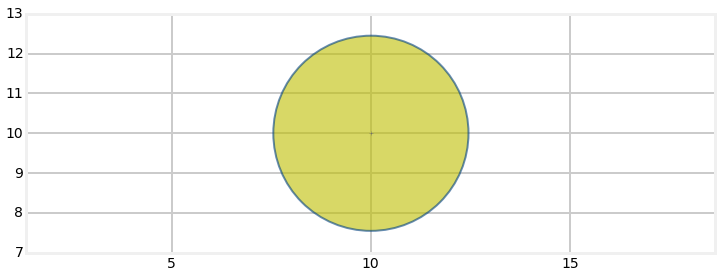

In [20]:
P0 = np.array([[6, 0], [0, 6]])
stats.plot_covariance_ellipse((10, 10), P0, facecolor='y', alpha=0.6)

Now suppose that there is a radar to the lower right of the aircraft. Further suppose that the radar is very accurate in the bearing measurement, but not very accurate at the range. That covariance, which is just the uncertainty in the reading might look like this (plotted in blue):

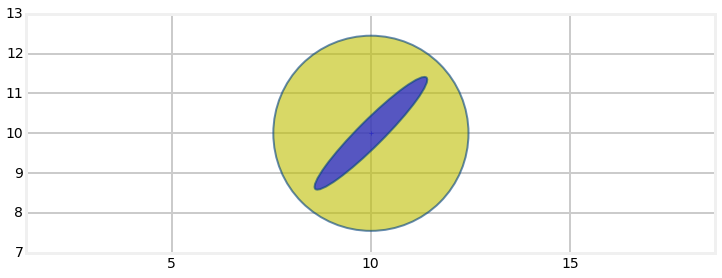

In [21]:
P1 = np.array([[2, 1.9], [1.9, 2]])
stats.plot_covariance_ellipse((10, 10), P0, facecolor='y', alpha=0.6)
stats.plot_covariance_ellipse((10, 10), P1, facecolor='b', alpha=0.6)

To combine the information we multiply the two Gaussians together. Let's see the result of that. I will use FilterPy's `multivariate_multiply` method to perform the multiplication.

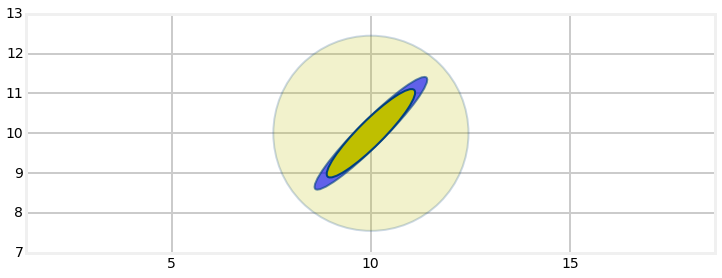

In [22]:
from stats import multivariate_multiply

P2 = multivariate_multiply((10, 10), P0, (10, 10), P1)[1]

stats.plot_covariance_ellipse((10, 10), P0, facecolor='y', alpha=0.2)
stats.plot_covariance_ellipse((10, 10), P1, facecolor='b', alpha=0.6)
stats.plot_covariance_ellipse((10, 10), P2, facecolor='y')

Here I have plotted the original estimate it a very transparent yellow, the radar reading in blue, and the estimate generate by multiplying the two Gaussians together in yellow.

It retained the same shape and position as the radar measurement, but is smaller. We've seen this with the one dimensional Gaussians - multiplying two Gaussians makes the variance smaller because we are incorporating more information, hence we are less uncertain.  But the main point I want to make is that the covariance shape reflects the physical layout of the aircraft and the radar system.

Now lets say we get a measurement from a second radar bank, this one to the lower right, which I will plot in blue against the yellow covariance of our current belief. 

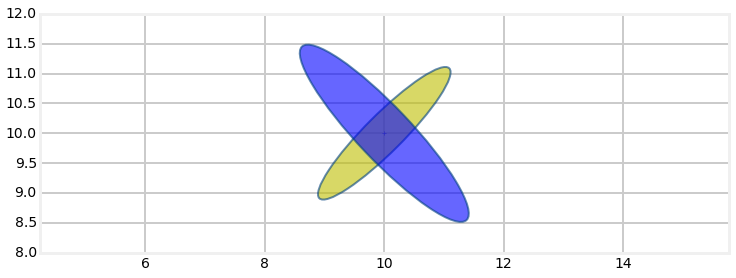

In [23]:
P3 = np.array([[2, -1.9], [-1.9, 2.2]])
stats.plot_covariance_ellipse((10, 10), P2, facecolor='y', alpha=0.6)
stats.plot_covariance_ellipse((10, 10), P3, facecolor='b', alpha=0.6)

Again, to incorporate this new information we will multiply the Gaussians together.

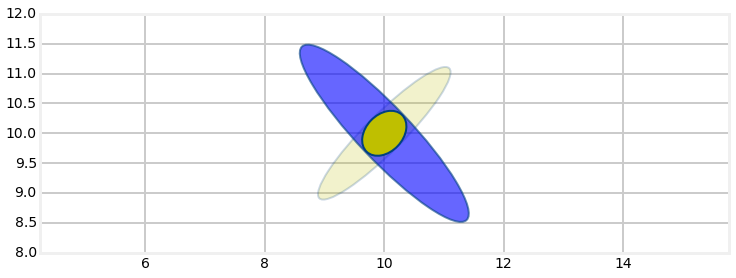

In [24]:
P4 = multivariate_multiply((10, 10), P2, (10, 10), P3)[1]

stats.plot_covariance_ellipse((10, 10), P2, facecolor='y', alpha=0.2)
stats.plot_covariance_ellipse((10, 10), P3, facecolor='b', alpha=0.6)
stats.plot_covariance_ellipse((10, 10), P4, facecolor='y')

You can see how the multivariate Gaussian's shape reflects the geometry of the problem. The first radar system was at a 45 degree angle to the aircraft, and its error in the bearing measurement was much smaller than the error in the range. This resulted in a long and narrow covariance ellipse whose major axis was aligned with the angle to the radar system. The next radar system was also at a 45 degree angle, but to the right, so the two measurements were orthogonal to each other. This allowed us to *triangulate* on the aircraft, which resulted in a very accurate final estimate. We didn't explicitly write any code to perform triangulation; it was a natural outcome of multiplying the Gaussians of each measurement together.

To make sure you understand this, what would the Gaussian look like if we only had one radar station, and we receive several measurements from it over a short period of time? Clearly the Gaussian would remain elongated in the axis of the bearing angle. Without a second radar station no information would be provided to reduce the error on that axis, so it would remain quite large. As the aircraft moves the bearing will typically change by a small amount, so over time some of the error will be reduced, but it will never be reduced as much as a second radar station would provide.

To round this out lets quickly redo this example but with the first radar system in a different position. I will position it directly to the left of the aircraft. The only change I need to make is to the Gaussian for the measurement from the radar. I used

$$\Sigma = \begin{bmatrix}2&1.9\\1.9&2\end{bmatrix}$$

Why did this result in a 45 degree ellipse? Think about that before reading on. It was 45 degrees because the values in the diagonal were identical. So if x=10 then y=10, and so on. We can alter the angle by making the variance for x or y different, like so:

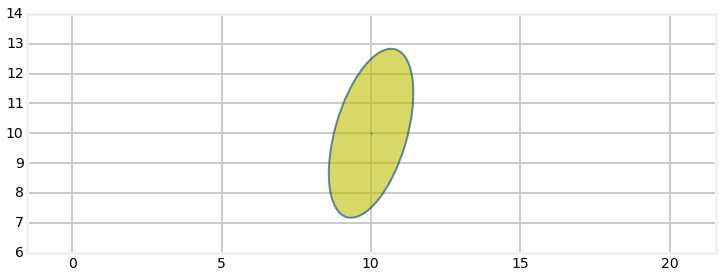

In [25]:
P1 = np.array([[2, 1.9], [1.9, 8]])
stats.plot_covariance_ellipse((10, 10), P1, facecolor='y', alpha=0.6)

The radar is to the left of the aircraft, so I can use a covariance of 

$$\Sigma = \begin{bmatrix}2&1.9\\1.9&2\end{bmatrix}$$

to model the measurement. In the next graph I plot the original estimate in a very light yellow, the radar measurement in blue, and the new estimate based on multiplying the two Gaussians together in yellow.

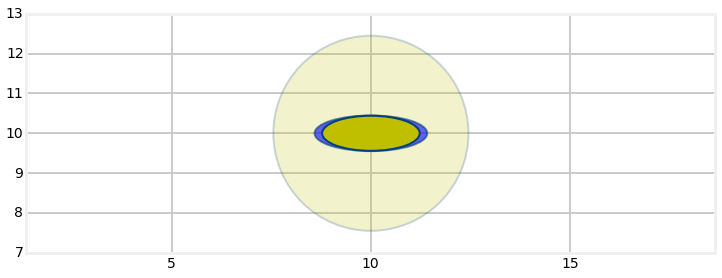

In [26]:
P1 = np.array([[2, 0], [0, .2]])

P2 = multivariate_multiply((10, 10), P0, (10, 10), P1)[1]

stats.plot_covariance_ellipse((10, 10), P0, facecolor='y', alpha=0.2)
stats.plot_covariance_ellipse((10, 10), P1, facecolor='b', alpha=0.6)
stats.plot_covariance_ellipse((10, 10), P2, facecolor='y')

Now we can incorporate the measurement from the second radar system, which we will leave in the same position as before.

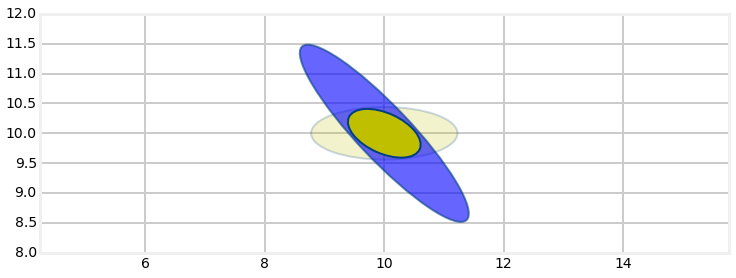

In [27]:
P3 = np.array([[2, -1.9], [-1.9, 2.2]])
P4 = multivariate_multiply((10, 10), P2, (10, 10), P3)[1]

stats.plot_covariance_ellipse((10, 10), P2, facecolor='y', alpha=0.2)
stats.plot_covariance_ellipse((10, 10), P3, facecolor='b', alpha=0.6)
stats.plot_covariance_ellipse((10, 10), P4, facecolor='y')

In this result our final estimate is not as accurate as the previous example. Why is that? The two radar stations were no longer othogonal to the aircraft's position so the triangulation is not optimal. Imagine standing on the ground and trying to triangulate on an aircraft in the sky with a transit. If you took a measurement, moved the transit 5 meters and took a second measurement the tiny change in angle between the two measurements would result in a very poor measurement because a very small error in either measurement would give a wildly different result. Think of the measurements as two nearly parallel lines. Changing the angle between them slightly will move the intersection between the two by a large amount. If you were to take the measurements from positions 100 km apart the lines might be nearly perpendicular to each other, in which case a small measurement error would result in a very small shift in the intersection point.

## Unobserved Variables

Let's say we are tracking an aircraft and we get the following data for the $x$ and $y$ coordinates at time $t$=1,2, and 3 seconds. What does your intuition tell you the value of $x$ will be at time $t$=4 seconds?

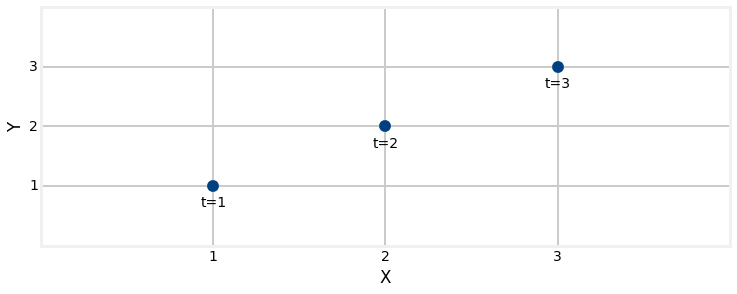

In [28]:
import mkf_internal
mkf_internal.show_position_chart()

It appears that the aircraft is flying in a straight line because we can draw a line between the three points, and we know that aircraft cannot turn on a dime. The most reasonable guess is that at $t$=4 the aircraft is at (4,4). I will depict that with a green arrow.

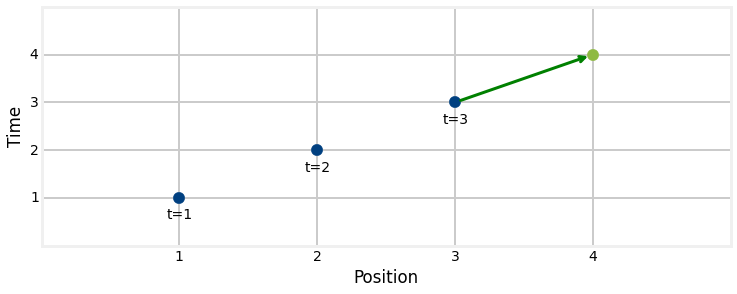

In [29]:
mkf_internal.show_position_prediction_chart()

You made this inference because you *inferred* a constant velocity for the airplane. The *reasonable* assumption is that the aircraft is moving one unit each in *x* and *y* per time step.

Think back to the g-h filter chapter when we were trying to improve the weight predictions of a noisy scale. We incorporated *weight gain* into the equations because it allowed us to make a better prediction of the weight the next day. The g-h filter uses the *g* parameter to scale the amount of significance given to the current weight measurement, and the *h* parameter scaled the amount of significance given to the weight gain.

We are going to do the same thing with our Kalman filter. After all, the Kalman filter is a form of a g-h filter (I have not proven this yet, but I will later on). In this case we are tracking an airplane, so instead of weight and weight gain we need to track position and velocity. Weight gain is the *derivative* of weight, and of course velocity is the derivative of position. Its hard to plot and understand the 3D chart that would be needed to plot *x* and *y* against time, so let's just do the 1D case.

So at time 1 we might be fairly certain about the position (x=0) but have no idea about the velocity. We can plot that with a covariance matrix like this. The narrow width expresses our relative certainty about position, and the tall height expresses our lack of knowledge about velocity.

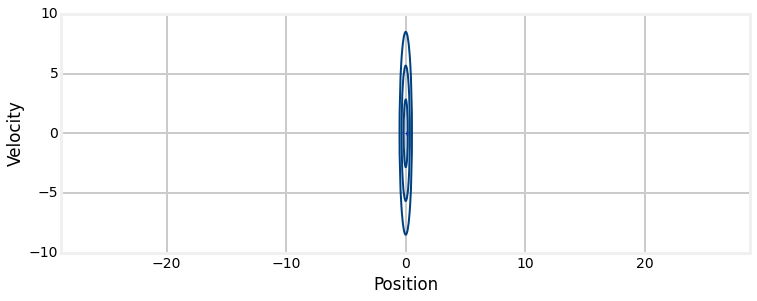

In [30]:
mkf_internal.show_x_error_chart(1)

Now after one second we get a position update of x=5. This implies that our velocity is roughly 5 m/s.

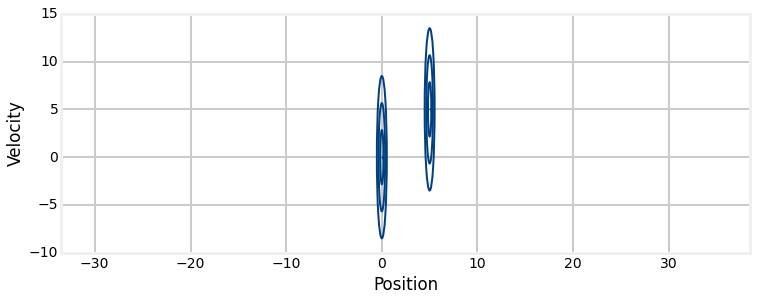

In [31]:
mkf_internal.show_x_error_chart(2)

But of course position and velocity are correlated. If the velocity is 5 m/s the position would be 5, but if the velocity was 10 m/s the position would be 10. So let's draw a velocity covariance matrix in red.

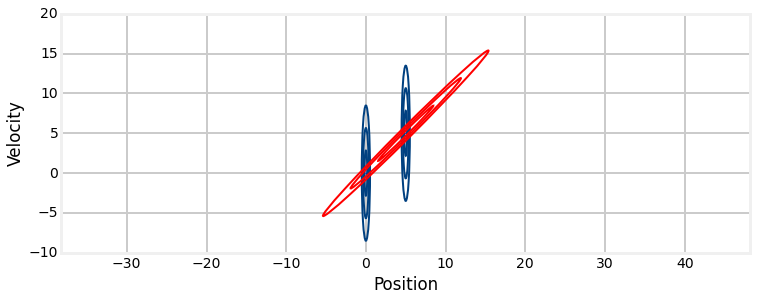

In [32]:
mkf_internal.show_x_error_chart(3)

This superposition of the two covariances is where all the magic happens. The only reasonable estimate at time t=1 (where position=5) is roughly the *intersection* between the two covariance matrices! More exactly, we can use the math from the last section and *multiply* the two covariances together. If we multiply the position covariance with the velocity covariance using the equations above, we get the result shown in the next chart.

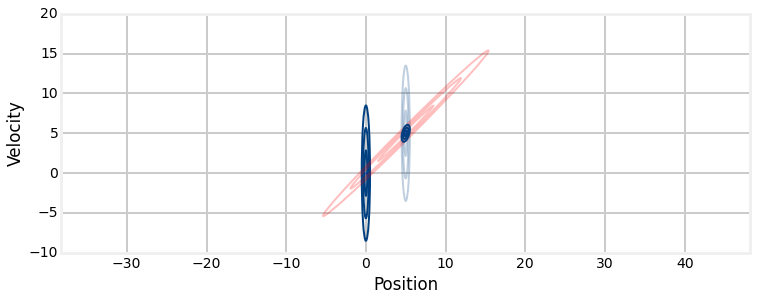

In [33]:
mkf_internal.show_x_error_chart(4)

We can see that the new covariance lies at the intersection of the position covariance and the velocity covariance. It is slightly tilted, showing that there is some correlation between the position and velocity. Far more importantly, it is far smaller than either the position or velocity covariances that make it up. In the previous chapter our variance would get smaller each time we performed an `update()` because the previous estimate's Gaussian was multiplied by the new measurement's Gaussian. The same thing is happening here. However, the amount that the covariance got smaller by is a huge amount in this chapter. This is because we are using two different kinds of information which are nevertheless correlated. Knowing the velocity approximately and the position approximately allows us to very quickly hone in on the correct answer. 

This is the **key point** in Kalman filters, so read carefully! Our sensor is only detecting the position of the aircraft (how doesn't matter). It does not have any kind of sensor that provides velocity to us. But based on the position estimates we can compute velocity. In Kalman filters we would call the velocity an *unobserved variable*. Unobserved means what it sounds like - there is no sensor that is measuring velocity directly. Since the velocity is based on the position, and the position has error, the velocity will have error as well. But as we can see the correlation between velocity and position means that we can very quickly eliminate most of that error.

What makes this possible? Imagine for a moment that we superimposed the velocity from a *different* airplane over the position graph. Clearly the two are not related, and there is no way that combining the two could possibly yield any additional information. In contrast, the velocity of the this airplane tells us something very important - the direction and speed of travel. So long as the aircraft does not alter its velocity the velocity allows us to predict where the next position is. After a relatively small amount of error in velocity the probability that it is a good match with the position is very small. Think about it - if you suddenly change direction your position is also going to change a lot. If the position measurement is not in the direction of the assumed velocity change it is very unlikely to be true. The two are correlated, so if the velocity changes so must the position, and in a predictable way. 

We are going to see this again and again in the rest of the book, so don't worry if this feels a bit magical to you. But it is important to understand that we are taking advantage of the fact that velocity and position are correlated coupled with the ability to infer velocity by looking at the distance and time between two measurement, to produce very accurate estimates after only a few observations. Please reread this section if you have any doubts. If you grasp this point the rest is straightforward. If you do not you will quickly find it impossible to reason about what you will learn in the rest of this chapter.

In summary we have taken advantage of the geometry and correlations of the system to produce a very accurate estimate. The math does not care whether we are working with two positions, or a position and a correlated velocity. If we can express our uncertainties as a multidimensional Gaussian we can then multiply our uncertainty in position with our uncertainty in velocity and get a much more accurate result, in exactly the same way we can multiply the uncertainty in two position estimates to get a more accurate result.

## Kalman Filter Algorithm

Now that we have that under our belts we can show how a multidimensional Kalman filter works. In the example above, we compute velocity from the previous position measurements using something called the *measurement function*. Then we predict the next position by using the current estimate and something called the *state transition function*. In our example above,

$$new\_position = old\_position + velocity*time$$ 

Next, we take the measurement from the sensor, and compare it to the prediction we just made. In a world with perfect sensors and perfect airplanes the prediction will always match the measured value. In the real world they will always be at least slightly different. We call the difference between the two the *residual*. Finally, we use something called the *Kalman gain* to update our estimate to be somewhere between the measured position and the predicted position. I will not describe how the gain is set, but suppose we had perfect confidence in our measurement - no error is possible. Then, clearly, we would set the gain so that 100% of the position came from the measurement, and 0% from the prediction. At the other extreme, if he have no confidence at all in the sensor (maybe it reported a hardware fault), we would set the gain so that 100% of the position came from the prediction, and 0% from the measurement. In normal cases, we will take a ratio of the two: maybe 53% of the measurement, and 47% of the prediction. The gain is updated on every cycle based on the variance of the variables (in a way yet to be explained). It should be clear that if the variance of the measurement is low, and the variance of the prediction is high we will favor the measurement, and vice versa. 

The chart shows a prior estimate of $x=2$ and a velocity $\dot{x}=1$. 

> We use the familiar dot notation $\dot{x}$ to denote the derivative of x with respect to time.

With the time step $\Delta t = 1$ we predict $x= 2+(1 \times 1) = 3$.

However, the new measurement is $z=2.3$, giving a residual $r=0.7$. Finally, the Kalman filter gain $K$ gives us a new estimate of $x=2.8$.

> We use the notation $z$ to denote a measurement. I will address notation in more detail later. It is an unfortunate reality that nearly every text on Kalman filtering uses different notation and variables - there is almost no agreement across texts. Be sure to read the introductory material very carefully to avoid being led astray.

## References

- [1] http://docs.scipy.org/doc/scipy/reference/tutorial/stats.html

- [2] https://en.wikipedia.org/wiki/Kalman_filter

- [3] Brown, Robert Grover. *Introduction to Random Signals and Applied Kalman Filtering* John Wiley & Sons, Inc. 2012

- [4] `FilterPy` library. Roger Labbe.
https://github.com/rlabbe/filterpy